In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import scipy as sc
import csv
import numpy as np
import seaborn as sb
from operator import itemgetter
from networkx.algorithms import community
from random import random
from matplotlib.lines import Line2D
from collections import Counter

In [2]:
def centralities(G, df: pd.DataFrame, method: str):
    '''
    A function to calculate degree, betweenness, closeness
    and eigenvector centralities (local properties)
    
    Inputs: nx object (graph)
            Pandas Data Frame of the Nodes
            string object (Degree, Betweenness, Closeness or Eigenvector )
    
    Output: Pandas Data Frame of Nodes with the centralities as attributes
    '''
    
    centr_list = []
    
    if method == "Degree":
        centr = nx.degree_centrality(G)
    
    elif method == "Betweenness":
        centr = nx.betweenness_centrality(G, weight = "Weights")
        
    elif method == "Closeness":
        centr = nx.closeness_centrality(G, distance = "Weights")
        
    elif method == "Eigen":
        centr = nx.eigenvector_centrality(G, weight = "weight")

    for key in centr:
        centr_list.append(centr[key])
            
    df[method] = centr_list

In [3]:
def structure_entropy(df: pd.DataFrame, n: int, method: str):
    
    values = df[method].values
    probabilities = []
    for _ in values:
        probability = _ / sum(values)
        probabilities.append(probability)
        
    # Entropy
    entropy = sc.stats.entropy(probabilities, base = 2)
    
    # Maximum Entropy
    max_entropy = np.log2(n)
    
    return entropy / max_entropy

In [4]:
def node_entropy(G, n:int, df: pd.DataFrame, method: str, i: str):
    
    '''
    A function that calculates the local and 
    mapping entropy for a node, to deduce
    its importance.
    
    Input: G -> Graph Object
           n -> number of nodes
           df -> pandas Data Frame with Centrality measures
           method -> "Mapping" or "Local"
           i -> node of interest
    
    Returns: float -> the entropy of the node
    '''
    
    neighbors = list(nx.neighbors(G, i))
    i_node = df.loc[i, "Degree"]
    
    if method == "Mapping":
        sum_map = 0
        for _ in neighbors:
            sum_map += np.log2(df.loc[_, "Degree"])
        
        maximum_val = i_node * len(neighbors) * np.log2(n - 1)
                                
        return -(sum_map * i_node) / maximum_val
    
    elif method == "Local":
        sum_loc = 0
        for _ in neighbors:
            deg_c = df.loc[_, "Degree"]
            sum_loc += (deg_c * np.log2(deg_c))
        
        maximum_val = len(neighbors) * (n-1) * np.log2(n - 1)
        return - sum_loc / maximum_val       

In [5]:
def removal(graph, methods: list, node: str, funct):
    '''
    A function that calculates centralities and entropies
    after the removal of a single node. If a disconnected network
    occurs, all the calculations are carried out on the largest connected
    component
    '''
    graph.remove_node(node)
    
    if nx.is_connected(graph):
        data_frame = pd.DataFrame({
            "Nodes": list(graph.nodes)
        })
        # Centralities
        for _ in methods:
            centralities(graph, data_frame, _)
        
        node_impact = {}
        for _ in methods:
            y =  {_: funct(data_frame, len(graph.nodes), _)}
            z = {_: initial_entropy[_] - y[_]}
            node_impact.update(z)
            
        return node_impact 
    
    else:
        # Connected and disconnected nodes
        connected = [i for i, d in graph.degree() if d > 0]
        disconnected = list(set(graph.nodes()) - set(connected))
        # Largest connected component
        graph_cc = sorted(nx.connected_components(graph), key = len, 
                     reverse = True)
        graph_large = graph.subgraph(graph_cc[0])
        
        # New data Frame
        data_frame = pd.DataFrame({
            "Nodes": list(graph_large.nodes)
        })
        # Centralities
        for _ in methods:
            centralities(graph_large, data_frame, _)
        
        # Impact of removed node on the graph entropy
        node_impact = {}
        for _ in methods:
            y =  {_: funct(data_frame, len(graph_large.nodes), _)}
            z = {_: initial_entropy[_] - y[_]}
            node_impact.update(z)
            
        return node_impact 

In [1]:
def attack_process(graph, ranking: list):
    
    # Generating a copy of the initial network
    H = graph.copy()
    
    # List of r-indices
    r_index_list = [0]
    
    # This loop stops running when the network becomes completely disconnected
    for _ in ranking:
        if _ in H.nodes:
            H.remove_node(_)
            if nx.is_connected(H):
                r_index =  1 - (H.size() / G.size())
                r_index_list.append(r_index)
            else:
                # Connected and disconnected nodes
                connected = [i for i, d in H.degree() if d > 0]
                disconnected = list(set(H.nodes()) - set(connected))
                # Largest connected component
                H_cc = sorted(nx.connected_components(H), key = len, 
                     reverse = True)
                H_large = H.subgraph(H_cc[0])
                H = H_large.copy()
                # Calculation of r-index
                r_index = 1 - (H.size() / G.size())
                r_index_list.append(r_index)
        else:
            continue
        
        # Completely disconnected network
        if len(H.edges) == 0:
            break
        
    return r_index_list

### Creating the Network

In [7]:
# Edgelist dataframe
dataset = pd.read_excel("JemaahE.xlsx")
df = pd.DataFrame(dataset)

# Creating the graph
G= nx.from_pandas_edgelist(df, "from", "to", edge_attr = ["weight"])

# Weight list
weights = list(df["weight"])

# Adding a new column with new weights as the reciprocal of the inicial ones
df["Weights"] = 1 / df["weight"]

# Printing some information
G.name = "Jemaah-Islamiyah terrorist cell"
nodes = list(G.nodes)
n = len(nodes)

In [8]:
# Creating a dataframe of the nodes and their attributes
node_df = pd.DataFrame({
    "Node": nodes,
    "Role": ["Command Team", "Operation Assistants", "Operation Assistants",
            "Command Team", "Bomb Makers", "Command Team", "Bomb Makers",
            "Bomb Makers", "Bomb Makers", "Bomb Makers", "Operation Assistants",
            "Suicide Bombers", "Suicide Bombers", "Team Lima", "Team Lima", 
            "Team Lima", "Team Lima"]
})

### Entropy based structural metrics

In [70]:
# Entropy of Weights
weight_prob_dist = df["weight"].value_counts(normalize = True)
weight_entropy = sc.stats.entropy(np.array(weight_prob_dist), 
                                 base = 2) / np.log2(len(df.weight.unique())) 
# Entropy of Member Role
member_role_prob_dist = node_df["Role"].value_counts(normalize = True)
member_role_entropy = sc.stats.entropy(np.array(member_role_prob_dist), 
                                      base = 2) / np.log2(len(node_df.Role.unique()))

In [11]:
print("Entropy of Weights:", weight_entropy, "\nRole Entropy: ", member_role_entropy)

Entropy of Weights: 0.7331036270382528 
Role Entropy:  0.9719977955078913


In [71]:
# Significance of weights
weight_significance = {}
for i in range(len(df.weight.unique())):
    df1 = df[df["weight"] != (i + 1)]
    weight_prob_dist_1 = df1["weight"].value_counts(normalize = True)
    weight_entropy_1 = sc.stats.entropy(np.array(weight_prob_dist_1), 
                                 base = 2) / np.log2(len(df1.weight.unique())) 
    weight_significance.update({"Weight = {}".format(i+1): weight_entropy - weight_entropy_1})
    df1 = df

# Results
weight_significance

{'Weight = 1': 0.11720912149216833,
 'Weight = 2': 0.006706811613687802,
 'Weight = 3': -0.04015076290949271,
 'Weight = 4': -0.0714215258187505,
 'Weight = 5': 0.1368682438446882}

In [72]:
# Role significance
member_role_significance = {}
for i in node_df.Role.unique():
    node_df1 = node_df[node_df["Role"] != i]
    member_role_prob_dist_1 = node_df1["Role"].value_counts(normalize = True)
    member_role_entropy_1 = sc.stats.entropy(np.array(role_prob_dist_1),
                                      base = 2) / np.log2(len(node_df1.Role.unique()))
    member_role_significance.update({"{}".format(i): member_role_entropy - member_role_entropy_1})
    node_df1 = node_df
        
# Results
member_role_significance

{'Command Team': 0.009910619357670791,
 'Operation Assistants': 0.009910619357670791,
 'Bomb Makers': 0.009910619357670791,
 'Suicide Bombers': 0.009910619357670791,
 'Team Lima': 0.009910619357670791}

### Centralities (no-entropy)

In [12]:
# Degree centrality
centralities(G, node_df, "Degree")
# Betweenness centrality
centralities(G, node_df, "Betweenness")
# Closeness centrality
centralities(G, node_df, "Closeness")
# Eigencentralities
centralities(G, node_df, "Eigen")

In [13]:
node_df.set_index("Node", inplace = True)
node_df

,Role,Degree,Betweenness,Closeness,Eigen
Node,,,,,
Muklas,Command Team,0.5625,0.020486,0.695652,0.173745
Amrozi,Operation Assistants,0.2500,0.002778,0.551724,0.091080
Imron,Operation Assistants,0.5625,0.014931,0.695652,0.419909
Samudra,Command Team,0.9375,0.510764,0.941176,0.270413
Dulmatin,Bomb Makers,0.5000,0.013889,0.666667,0.346147
Idris,Command Team,0.6250,0.052431,0.727273,0.289026
Azahari,Bomb Makers,0.5625,0.014931,0.695652,0.330681
Ghoni,Bomb Makers,0.5625,0.014931,0.695652,0.396102
Patek,Bomb Makers,0.5625,0.014931,0.695652,0.363889


### Centralities (entropic)

#### A. By measuring Impact

In [15]:
# Graph Entropy (no nodes removed)
initial_entropy = {}
methods = ["Degree", "Betweenness", "Closeness", "Eigen"]
for i in methods: 
    x = {i: structure_entropy(node_df, n, i)}
    initial_entropy.update(x)
initial_entropy

{'Degree': 0.9737450909973391,
 'Betweenness': 0.368890775789418,
 'Closeness': 0.9956073582102462,
 'Eigen': 0.8859783370751618}

In [16]:
# Initializing Removal Process
results = {}
for i in nodes:
    # Copy of initial network
    H = G.copy()
    value = {i: removal(H, methods, i, structure_entropy)}
    results.update(value)

In [17]:
entropies_df = pd.DataFrame({
    "Nodes": [_ for _ in results],
    "Entropy Degree": [results[_]["Degree"] for _ in results],
    "Entropy Bet.": [results[_]["Betweenness"] for _ in results],
    "Entropy Close.": [results[_]["Closeness"] for _ in results],
    "Entropy Eigen.": [results[_]["Eigen"] for _ in results]
})

###### B) Mapping and Local Entropy

In [18]:
alt_entropy = pd.DataFrame({
    "Nodes": list(G.nodes),
    "Local Entropy": [node_entropy(G, n, node_df, "Local", _) for _ in G.nodes],
    "Mapping Entropy": [node_entropy(G, n, node_df, "Mapping", _) for _ in G.nodes]
})
alt_entropy

,Nodes,Local Entropy,Mapping Entropy
0,Muklas,0.006734,0.224763
1,Amrozi,0.005589,0.251018
2,Imron,0.006787,0.208514
3,Samudra,0.007639,0.327231
4,Dulmatin,0.006594,0.198019
5,Idris,0.006835,0.266463
6,Azahari,0.006787,0.208514
7,Ghoni,0.006787,0.208514
8,Patek,0.006787,0.208514
9,Sarijo,0.006594,0.198019


### Visualization

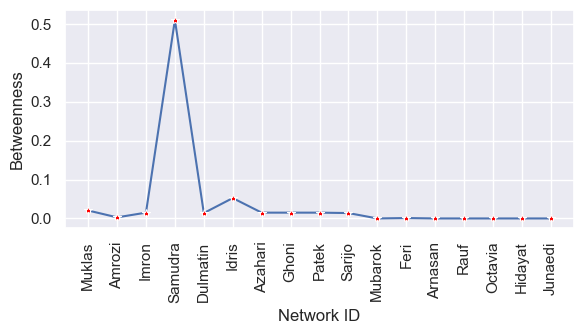

In [19]:
sb.set(rc={'figure.figsize':(6, 3.5)})
plt.figure()
plot_sb = sb.lineplot(x="Node", y="Betweenness", data = node_df, 
            marker='*', markerfacecolor='red')
plt.xlabel("Network ID")
plt.ylabel("Betweenness")


plt.xticks(rotation = 90)

plt.tight_layout()
plt.show()

figure = plot_sb.get_figure()    
#figure.savefig('Betweenness.png', dpi=400)

### Ranking

In [20]:
# Ranking based on Centrality
degree_rank = list(node_df.sort_values(by = ["Degree"], ascending = False).index)
between_rank = list(node_df.sort_values(by = ["Betweenness"], ascending = False).index)

In [21]:
entropies_df["Absolute Variation (Degree)"] = abs(entropies_df["Entropy Degree"].values)
entropies_df["Absolute Var. Bet."] = abs(entropies_df["Entropy Bet."].values)
entropies_df.set_index("Nodes", inplace = True)

In [22]:
# Ranking based on Impact Entropy
entr_deg_rank = list(entropies_df.sort_values(by = ["Absolute Variation (Degree)"], 
                                             ascending = False).index)
entr_bet_rank = list(entropies_df.sort_values(by = ["Absolute Var. Bet."],
                                             ascending = False).index)

In [23]:
alt_entropy.set_index("Nodes", inplace = True)
# Ranking based on Mapping and Local Entropy
map_rank = list(alt_entropy.sort_values(by = ["Mapping Entropy"],
                                       ascending = False).index)
local_rank = list(alt_entropy.sort_values(by = ["Local Entropy"], 
                                         ascending = False).index)

In [24]:
ranking_df = pd.DataFrame({
    "Degree": degree_rank,
    "Betweenness": between_rank,
    "ED": entr_deg_rank,
    "EB": entr_bet_rank,
    "Mapping": map_rank,
    "Local": local_rank
})
ranking_df

,Degree,Betweenness,ED,EB,Mapping,Local
0,Samudra,Samudra,Junaedi,Samudra,Junaedi,Samudra
1,Idris,Idris,Hidayat,Feri,Hidayat,Feri
2,Muklas,Muklas,Octavia,Idris,Octavia,Idris
3,Ghoni,Ghoni,Rauf,Amrozi,Rauf,Junaedi
4,Azahari,Azahari,Arnasan,Junaedi,Arnasan,Hidayat
5,Patek,Patek,Mubarok,Hidayat,Samudra,Octavia
6,Imron,Imron,Idris,Octavia,Idris,Rauf
7,Dulmatin,Dulmatin,Imron,Rauf,Amrozi,Arnasan
8,Sarijo,Sarijo,Patek,Arnasan,Mubarok,Patek
9,Feri,Amrozi,Ghoni,Muklas,Muklas,Ghoni


### Attacking the network

In [25]:
# Attack process: r-indices for every scenarion saved in a list
indices_list = []

for _ in ranking_df.columns:
    x = attack_process(G, ranking_df[_])
    indices_list.append(x)

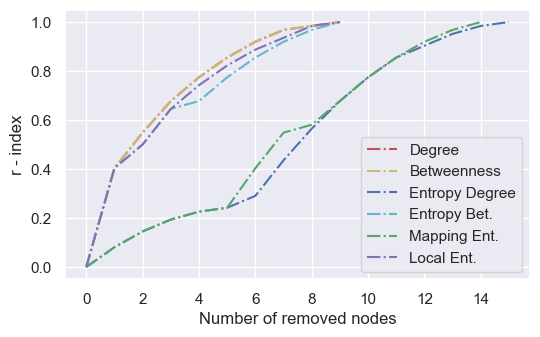

In [26]:
plt.plot(np.arange(len(indices_list[0])), indices_list[0], "r-.", label = "Degree")
plt.plot(np.arange(len(indices_list[1])), indices_list[1], "y-.", label = "Betweenness")
plt.plot(np.arange(len(indices_list[2])), indices_list[2], "b-.", label = "Entropy Degree")
plt.plot(np.arange(len(indices_list[3])), indices_list[3], "c-.", label = "Entropy Bet.")
plt.plot(np.arange(len(indices_list[4])), indices_list[4], "g-.", label = "Mapping Ent.")
plt.plot(np.arange(len(indices_list[5])), indices_list[5], "m-.", label = "Local Ent.")
plt.xlabel('Number of removed nodes')
plt.ylabel('r - index')
plt.legend()
plt.grid("on")
#plt.savefig("R-index Bali.png")
plt.show()